## Lean TaaS Problem Set
#### Oct 2019 | Michael Furr

#### Import Libraries

In [1]:
import pandas as pd
import sqlite3

from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import cufflinks as cf

init_notebook_mode(connected=True)

cf.go_offline()

#### Pull in data

In [2]:
conn = sqlite3.connect('LeanTaaSTestDB.db')
df = pd.read_sql_query("SELECT * FROM exchange_transactions;", conn)
df['created_datetime'] = df['created_datetime'].apply(lambda x: x.split('.')[0])
df['created_datetime'] = pd.to_datetime(df['created_datetime'])

df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

In [3]:
df.head()

,transaction_id,parent_transaction_id,action,scheduler,surgeon,created_datetime,snapshot_date,start_time,end_time,room_name,location
0,2c91808267d2ea5301682f73e9a1093e,None,RELEASE,Jessie Shelley,Bryan Neer,2019-01-15 13:52:32,2019-07-01 00:00:00.000000,2019-10-13 07:30:00,2019-10-13 19:00:00,MRAH OR 03,CENTER
1,2c91808267d2ea5301683984e52b0bfb,None,TRANSFER,Raymond Smith,Charles Mcdonald,2019-01-17 12:47:17,2019-06-20 00:00:00.000000,2019-10-13 07:30:00,2019-10-13 19:00:00,MRAH OR 06,CENTER
2,2c91808267d2ea53016839855a480bfc,None,TRANSFER,Raymond Smith,Charles Mcdonald,2019-01-17 12:47:47,2019-06-20 00:00:00.000000,2019-10-13 07:30:00,2019-10-13 19:00:00,MNOR 36,CENTER
3,2c91808267d2eb4b016829281a390786,None,RELEASE,Kimberly Bugg,Joann Hinson,2019-01-14 08:32:01,2019-06-12 00:00:00.000000,2019-10-13 08:50:00,2019-10-13 19:00:00,MNOR 25,CENTER
4,2c91808267d2eb4b01682977274607cb,2c91808267d2eb4b016829281a390786,MARK_UPDATED,Dora Smith,Joann Hinson,2019-01-14 09:58:21,2019-06-12 00:00:00.000000,2019-10-13 08:50:00,2019-10-13 19:00:00,MNOR 25,CENTER


#### Question 1
#### How many minutes of requests, transfers and releases have been completed? The marketplace is successful if there's a good amount of activities from both sides.

In [4]:
def releaseTime_timeBlock(df):
    """
    Returns the duration of the scheduling block associated with the original transaction

    Args:
        df (pd.DataFrame): a DataFrame containing data from the exchange_transactions table of the LeanTaaSTestDB.db

    Returns:
        releaseTime (list): xxxxx
        totalReleaseTime (float): xxxxx
    """
    
    # get each unqiue Release_ID
    releaseTime = []
    Release_IDs = []
    for i in range(0, len(df)):
        if df['action'][i] == 'RELEASE':
            releaseTime.append(df['end_time'][i] - df['start_time'][i])

    # calculate the releaseTime in seconds
    for i in range(0, len(releaseTime)):
        releaseTime[i] = releaseTime[i].total_seconds()/60
        
    totalReleaseTime = sum(releaseTime)
    return releaseTime, totalReleaseTime

releaseTime_timeBlock, totalReleaseTime_timeBlock = releaseTime_timeBlock(df)

In [5]:
def transferTime_timeBlock(df):
    """
    Returns the duration of the scheduling block associated with the original transaction

    Args:
        df (pd.DataFrame): a DataFrame containing data from the exchange_transactions table of the LeanTaaSTestDB.db

    Returns:
        transferTime (list): xxxxx
        totalTransferTime (float): xxxxx
    """
    
    transferTime = []
    for i in range(0, len(df)):
        if df['action'][i] == 'TRANSFER':
            transferTime.append(df['end_time'][i] - df['start_time'][i])

    # calculate the transferTime in seconds
    for i in range(0, len(transferTime)):
        transferTime[i] = transferTime[i].total_seconds()/60
        
    totalTransferTime = sum(transferTime)
    return transferTime, totalTransferTime

transferTime_timeBlock, totalTransferTime_timeBlock = transferTime_timeBlock(df)


In [6]:
def requestTime_timeBlock(df):
    """
    Returns the duration of the scheduling block associated with the original transaction

    Args:
        df (pd.DataFrame): a DataFrame containing data from the exchange_transactions table of the LeanTaaSTestDB.db

    Returns:
        requestTime (list): xxxxx
        totalRequestTime (float): xxxxx
    """
    
    requestTime = []
    for i in range(0, len(df)):
        if df['action'][i] == 'REQUEST':
            requestTime.append(df['end_time'][i] - df['start_time'][i])

    # calculate the requestTime in seconds
    for i in range(0, len(requestTime)):
        requestTime[i] = requestTime[i].total_seconds()/60
        
    totalRequestTime = sum(requestTime)
    return requestTime, totalRequestTime

requestTime_timeBlock, totalRequestTime_timeBlock = requestTime_timeBlock(df)

In [7]:
def releaseTime(df):
    """
    Returns the release time and total release time for each release ID

    Args:
        df (pd.DataFrame): a DataFrame containing data from the exchange_transactions table of the LeanTaaSTestDB.db

    Returns:
        Release_IDs (list): xxxxx
        releaseTime (list): xxxxx
        totalReleaseTime (float): xxxxx
    """
    
    # get each unqiue Release_ID
    Release_IDs = []
    for i in range(0, len(df)):
        if df['action'][i] == 'RELEASE':
            Release_IDs.append(df['transaction_id'][i])
    
    # calculate the release time from each Release_ID
    releaseTime = []
    for i in range(0, len(Release_IDs)):
        releaseTime.append(df[df['parent_transaction_id'] == Release_IDs[i]]['created_datetime'][df.index[df['parent_transaction_id'] == Release_IDs[i]][0]] - df[df['transaction_id'] == Release_IDs[i]]['created_datetime'][df.index[df['transaction_id'] == Release_IDs[i]][0]])
    
    # calculate the releaseTime in seconds
    for i in range(0, len(releaseTime)):
        releaseTime[i] = releaseTime[i].total_seconds()/60
        
    totalReleaseTime = sum(releaseTime)
    return Release_IDs, releaseTime, totalReleaseTime

Release_IDs, releaseTime, totalReleaseTime = releaseTime(df)

In [8]:
def transferTime(df):
    """
    Returns the transfer time and total transfer time for reach transaction
    
    Args:
        df (pd.DataFrame): a DataFrame containing data from the exchange_transactions table of the LeanTaaSTestDB.db
        
    Returns:
        Transfer_IDs (list): xxxxx
        transferTime (list): xxxxx
        totalTransferTime (float): xxxxx
    """
    
    Transfer_IDs = []
    for i in range(0, len(df)):
        if df['action'][i] == 'TRANSFER':
            Transfer_IDs.append(df['transaction_id'][i])
            
    transferTime = []
    for i in range(0, len(Transfer_IDs)):
        
        a = df[df['parent_transaction_id'] == Transfer_IDs[i]]
        
        if len(a[a['action'] == 'MARK_UPDATED']) == 1:
            index_a = a.index[a['action'] == 'MARK_UPDATED'][0]
            b = df[df['transaction_id'] == Transfer_IDs[i]]
            index_b = b.index[0]
            transferTime.append(a['created_datetime'][index_a] - b['created_datetime'][index_b])
            
        elif len(a[a['action'] == 'DENY_TRANSFER']) == 1:
            index_a = a.index[a['action'] == 'DENY_TRANSFER'][0]
            b = df[df['transaction_id'] == Transfer_IDs[i]]
            index_b = b.index[0]
            transferTime.append(a['created_datetime'][index_a] - b['created_datetime'][index_b])
        
    for i in range(0, len(transferTime)):
        transferTime[i] = transferTime[i].total_seconds()/60
        
    totalTransferTime = sum(transferTime)
    
    return Transfer_IDs, transferTime, totalTransferTime

Transfer_IDs, transferTime, totalTransferTime = transferTime(df)

In [9]:
def requestTime(df):
    """
    Returns the request time and total transfer time for reach transaction
    
    Args:
        df (pd.DataFrame): a DataFrame containing data from the exchange_transactions table of the LeanTaaSTestDB.db
        
    Returns:
        Request_IDs (list): xxxxx
        requestTime (list): xxxxx
        totalRequestTime (float): xxxxx
    """
    
    Request_IDs = []
    for i in range(0, len(df)):
        if df['action'][i] == 'REQUEST':
            Request_IDs.append(df['transaction_id'][i])
            
    requestTime = []
    for i in range(0, len(Request_IDs)):
        
        a = df[df['parent_transaction_id'] == Request_IDs[i]]
    
        if len(a[a['action'] == 'MARK_UPDATED']) == 1:
            index_a = a.index[a['action'] == 'MARK_UPDATED'][0]
            b = df[df['transaction_id'] == Request_IDs[i]]
            index_b = b.index[0]
            requestTime.append(a['created_datetime'][index_a] - b['created_datetime'][index_b])

        elif len(a[a['action'] == 'DENY_REQUEST']) == 1:            
            index_a = a.index[a['action'] == 'DENY_REQUEST'][0]
            b = df[df['transaction_id'] == Request_IDs[i]]
            index_b = b.index[0]
            transferTime.append(a['created_datetime'][index_a] - b['created_datetime'][index_b])
        
    for i in range(0, len(requestTime)):
        requestTime[i] = requestTime[i].total_seconds()/60
        
    totalRequestTime = sum(requestTime)
        
    return Request_IDs, requestTime, totalRequestTime

Request_IDs, requestTime, totalRequestTime = requestTime(df)

### EDA and Data Analysis

In [10]:
results = pd.DataFrame([totalRequestTime, totalTransferTime, totalReleaseTime], columns = ['Total Duration (min)'])
results.sort_values('Total Duration (min)', inplace = True)
results['Action Type'] = ['Transfer', 'Release', 'Request']
results

,Total Duration (min),Action Type
1,140820.80,Transfer
2,512316.25,Release
0,710037.45,Request


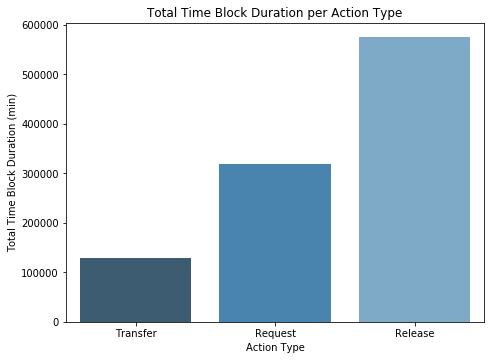

In [11]:
resultsTimeBlock = pd.DataFrame([totalRequestTime_timeBlock, totalTransferTime_timeBlock, \
                        totalReleaseTime_timeBlock], columns = ['Total Time Block Duration (min)'])
resultsTimeBlock.sort_values('Total Time Block Duration (min)', inplace = True)
resultsTimeBlock['Action Type'] = ['Transfer', 'Request', 'Release']

fig12 = plt.figure(figsize = (7.5, 5.5))
plt.title('Total Time Block Duration per Action Type')
sns.barplot(x = 'Action Type', y = 'Total Time Block Duration (min)', \
            data = resultsTimeBlock, palette = 'Blues_d')
fig12.savefig('Total_TimeBlock_Duration.png')

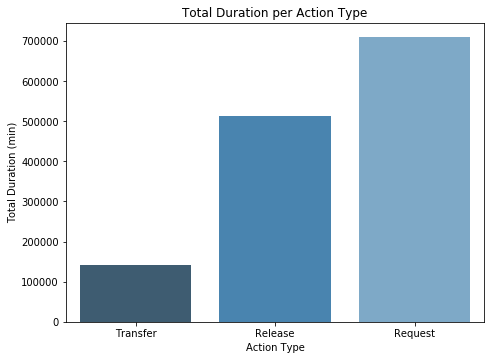

In [12]:
fig1 = plt.figure(figsize = (7.5, 5.5))
plt.title('Total Duration per Action Type')
sns.barplot(x = 'Action Type', y = 'Total Duration (min)', data = results, palette = 'Blues_d')
fig1.savefig('Total_Action_Duration.png')

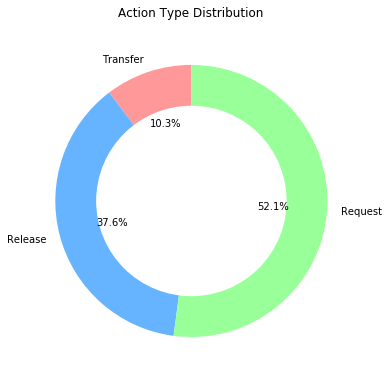

In [13]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

fig1, ax1 = plt.subplots(figsize = (5.5, 5.5))
ax1.pie(results['Total Duration (min)'], colors = colors, labels = results['Action Type'], autopct='%1.1f%%', startangle=90)
plt.title('Action Type Distribution')

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()

In [14]:
results.iplot(kind = 'bar', x = 'Action Type', 
              y = 'Total Duration (min)', 
              title = 'Total Duration per Action Type', 
             xTitle = 'Action Type', 
             yTitle = 'Total Duration (min)', color = 'rgba(50, 171, 96, 1.0)')

In [15]:
df.head()

,transaction_id,parent_transaction_id,action,scheduler,surgeon,created_datetime,snapshot_date,start_time,end_time,room_name,location
0,2c91808267d2ea5301682f73e9a1093e,None,RELEASE,Jessie Shelley,Bryan Neer,2019-01-15 13:52:32,2019-07-01 00:00:00.000000,2019-10-13 07:30:00,2019-10-13 19:00:00,MRAH OR 03,CENTER
1,2c91808267d2ea5301683984e52b0bfb,None,TRANSFER,Raymond Smith,Charles Mcdonald,2019-01-17 12:47:17,2019-06-20 00:00:00.000000,2019-10-13 07:30:00,2019-10-13 19:00:00,MRAH OR 06,CENTER
2,2c91808267d2ea53016839855a480bfc,None,TRANSFER,Raymond Smith,Charles Mcdonald,2019-01-17 12:47:47,2019-06-20 00:00:00.000000,2019-10-13 07:30:00,2019-10-13 19:00:00,MNOR 36,CENTER
3,2c91808267d2eb4b016829281a390786,None,RELEASE,Kimberly Bugg,Joann Hinson,2019-01-14 08:32:01,2019-06-12 00:00:00.000000,2019-10-13 08:50:00,2019-10-13 19:00:00,MNOR 25,CENTER
4,2c91808267d2eb4b01682977274607cb,2c91808267d2eb4b016829281a390786,MARK_UPDATED,Dora Smith,Joann Hinson,2019-01-14 09:58:21,2019-06-12 00:00:00.000000,2019-10-13 08:50:00,2019-10-13 19:00:00,MNOR 25,CENTER


In [16]:
len(Transfer_IDs)

264

In [17]:
len(Release_IDs)

1201

In [18]:
len(Request_IDs)

1324

<BarContainer object of 3 artists>

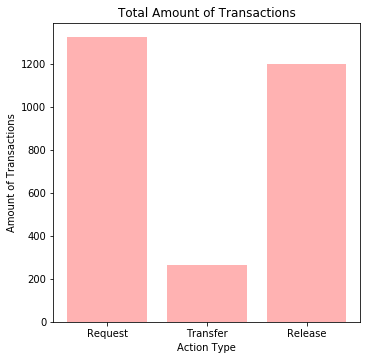

In [19]:
plt.figure(figsize = (5.5, 5.5))
plt.title('Total Amount of Transactions')
plt.xlabel('Action Type')
plt.ylabel('Amount of Transactions')
plt.bar(x = ['Request', 'Transfer', 'Release'], 
        height = [len(Request_IDs), 
                  len(Transfer_IDs), 
                 len(Release_IDs)], 
                    color = 'r', alpha = 0.3)

<BarContainer object of 2 artists>

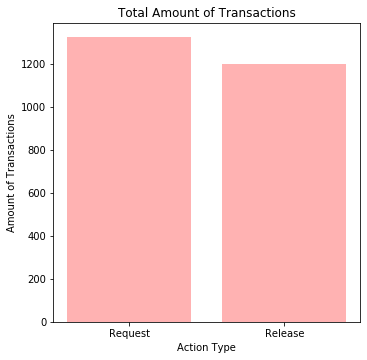

In [20]:
plt.figure(figsize = (5.5, 5.5))
plt.title('Total Amount of Transactions')
plt.xlabel('Action Type')
plt.ylabel('Amount of Transactions')
plt.bar(x = ['Request', 'Release'], 
        height = [len(Request_IDs), 
                  len(Release_IDs)], 
                    color = 'r', alpha = 0.3)

In [21]:
by_surgeon = df[df['action'] == 'RELEASE'].groupby(['surgeon', 'action'])

In [22]:
sorted = by_surgeon.count()

In [23]:
sorted.nlargest(5, 'transaction_id')

,,transaction_id,parent_transaction_id,scheduler,created_datetime,snapshot_date,start_time,end_time,room_name,location
surgeon,action,,,,,,,,,
Dorothy Shaver,RELEASE,21,0,21,21,21,21,21,21,21
Mikel Smith,RELEASE,19,0,19,19,19,19,19,19,19
Daniel Finney,RELEASE,18,0,18,18,18,18,18,18,18
Gregory Hunt,RELEASE,17,0,17,17,17,17,17,17,17
James Mcnutt,RELEASE,14,0,14,14,14,14,14,14,14


### Question 2

#### What is the denial rate and response time? The marketplace is easy to use if transactions are both quick and easy.

In [24]:
df.head()

,transaction_id,parent_transaction_id,action,scheduler,surgeon,created_datetime,snapshot_date,start_time,end_time,room_name,location
0,2c91808267d2ea5301682f73e9a1093e,None,RELEASE,Jessie Shelley,Bryan Neer,2019-01-15 13:52:32,2019-07-01 00:00:00.000000,2019-10-13 07:30:00,2019-10-13 19:00:00,MRAH OR 03,CENTER
1,2c91808267d2ea5301683984e52b0bfb,None,TRANSFER,Raymond Smith,Charles Mcdonald,2019-01-17 12:47:17,2019-06-20 00:00:00.000000,2019-10-13 07:30:00,2019-10-13 19:00:00,MRAH OR 06,CENTER
2,2c91808267d2ea53016839855a480bfc,None,TRANSFER,Raymond Smith,Charles Mcdonald,2019-01-17 12:47:47,2019-06-20 00:00:00.000000,2019-10-13 07:30:00,2019-10-13 19:00:00,MNOR 36,CENTER
3,2c91808267d2eb4b016829281a390786,None,RELEASE,Kimberly Bugg,Joann Hinson,2019-01-14 08:32:01,2019-06-12 00:00:00.000000,2019-10-13 08:50:00,2019-10-13 19:00:00,MNOR 25,CENTER
4,2c91808267d2eb4b01682977274607cb,2c91808267d2eb4b016829281a390786,MARK_UPDATED,Dora Smith,Joann Hinson,2019-01-14 09:58:21,2019-06-12 00:00:00.000000,2019-10-13 08:50:00,2019-10-13 19:00:00,MNOR 25,CENTER


In [25]:
def transferApproval(df):
    """
    Returns the transfer approval and denial transaction IDs

    Args:
        df (pd.DataFrame): a DataFrame containing data from the exchange_transactions table of the LeanTaaSTestDB.db

    Returns:
        transferApproval_ID (list): xxxxx
        transferDenial_ID (list): xxxxx
    """

    transferApproval_ID = []
    transferDenial_ID = []
    for i in range(0, len(Transfer_IDs)):

            a = df[df['parent_transaction_id'] == Transfer_IDs[i]]

            if len(a[a['action'] == 'APPROVE_TRANSFER']) == 1:
                if len(a[a['action'] == 'MARK_UPDATED']) == 1:
                    index_a = a.index[a['action'] == 'APPROVE_TRANSFER'][0]
                    transferApproval_ID.append(index_a)

            elif len(a[a['action'] == 'DENY_TRANSFER']) == 1:
                index_a = a.index[a['action'] == 'DENY_TRANSFER'][0]
                transferDenial_ID.append(index_a)
                
    return transferApproval_ID, transferDenial_ID

transferApproval_ID, transferDenial_ID = transferApproval(df)

In [26]:
totalApprovedTransfers = len(transferApproval_ID)
totalDeniedTransfers = len(transferDenial_ID)

Approval_Rate_Transfers = totalApprovedTransfers / (totalApprovedTransfers + totalDeniedTransfers)
Denial_Rate_Transfers = totalDeniedTransfers / (totalApprovedTransfers + totalDeniedTransfers)

In [27]:
Denial_Rate_Transfers

0.026717557251908396

In [28]:
Approval_Rate_Transfers

0.9732824427480916

### EDA

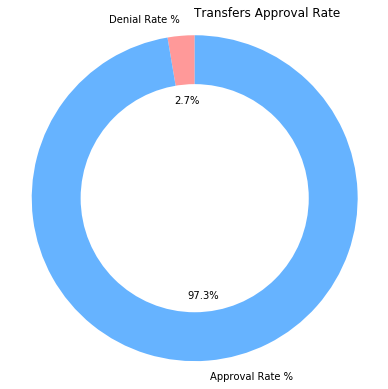

In [29]:
labels = ['Denial Rate %', 'Approval Rate %']

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

fig1, ax1 = plt.subplots(figsize = (5.5, 5.5))
ax1.pie([Denial_Rate_Transfers, Approval_Rate_Transfers], labels = labels, colors = colors, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.title('Transfers Approval Rate', {'horizontalalignment': 'left'})
plt.tight_layout()

In [30]:
def requestApproval(df):
    """
    Returns the request approval and denial transaction IDs

    Args:
        df (pd.DataFrame): a DataFrame containing data from the exchange_transactions table of the LeanTaaSTestDB.db

    Returns:
        requestApproval_ID (list): xxxxx
        requestDenial_ID (list): xxxxx
    """

    requestApproval_ID = []
    requestDenial_ID = []
    for i in range(0, len(Request_IDs)):

            a = df[df['parent_transaction_id'] == Request_IDs[i]]

            if len(a[a['action'] == 'APPROVE_REQUEST']) == 1:
                if len(a[a['action'] == 'MARK_UPDATED']) == 1:
                    index_a = a.index[a['action'] == 'APPROVE_REQUEST'][0]
                    requestApproval_ID.append(index_a)

            elif len(a[a['action'] == 'DENY_REQUEST']) == 1:
                index_a = a.index[a['action'] == 'DENY_REQUEST'][0]
                requestDenial_ID.append(index_a)
                
    return requestApproval_ID, requestDenial_ID
    
requestApproval_ID, requestDenial_ID = requestApproval(df)

In [31]:
totalApprovedRequests = len(requestApproval_ID)
totalDeniedRequests = len(requestDenial_ID)

Approval_Rate_Requests = totalApprovedRequests / (totalApprovedRequests + totalDeniedRequests)
Denial_Rate_Requests = totalDeniedRequests / (totalApprovedRequests + totalDeniedRequests)

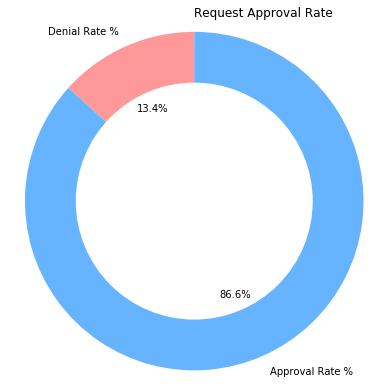

In [32]:
labels = ['Denial Rate %', 'Approval Rate %']

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

fig1, ax1 = plt.subplots(figsize = (5.5, 5.5))
ax1.pie([Denial_Rate_Requests, Approval_Rate_Requests], labels = labels, colors = colors, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Request Approval Rate', {'horizontalalignment': 'left'})
ax1.axis('equal')  
plt.tight_layout()

In [33]:
def responseTimeTransfer(df):
    """
    Returns the response time for transfer transactions

    Args:
        df (pd.DataFrame): a DataFrame containing data from the exchange_transactions table of the LeanTaaSTestDB.db

    Returns:
        responseTimeTransfer (list): xxxxx
    """

    responseTimeTransfer = []
    for i in range(0, len(Transfer_IDs)):

            a = df[df['parent_transaction_id'] == Transfer_IDs[i]]
            b = df[df['transaction_id'] == Transfer_IDs[i]]
            index_b = b.index[0]

            if len(a[a['action'] == 'APPROVE_TRANSFER']) == 1:
                if len(a[a['action'] == 'MARK_UPDATED']) == 1:
                    index_a = a.index[a['action'] == 'APPROVE_TRANSFER'][0]
                    responseTimeTransfer.append(a['created_datetime'][index_a] - b['created_datetime'][index_b])

            elif len(a[a['action'] == 'DENY_TRANSFER']) == 1:
                index_a = a.index[a['action'] == 'DENY_TRANSFER'][0]
                responseTimeTransfer.append(a['created_datetime'][index_a] - b['created_datetime'][index_b])
                
    return responseTimeTransfer

responseTimeTransfer = responseTimeTransfer(df)

In [34]:
for i in range(0, len(responseTimeTransfer)):
    
    responseTimeTransfer[i] = responseTimeTransfer[i].total_seconds()/60

averageResponseTimeTransfer = sum(responseTimeTransfer) / len(responseTimeTransfer)

In [35]:
def responseTimeRequest(df):
    """
    Returns the response time for request transactions

    Args:
        df (pd.DataFrame): a DataFrame containing data from the exchange_transactions table of the LeanTaaSTestDB.db

    Returns:
        responseTimeRequest (list): xxxxx
    """

    responseTimeRequest = []
    for i in range(0, len(Request_IDs)):
            a = df[df['parent_transaction_id'] == Request_IDs[i]]
            b = df[df['transaction_id'] == Request_IDs[i]]
            index_b = b.index[0]

            if len(a[a['action'] == 'APPROVE_REQUEST']) == 1:
                if len(a[a['action'] == 'MARK_UPDATED']) == 1:
                    index_a = a.index[a['action'] == 'APPROVE_REQUEST'][0]
                    responseTimeRequest.append(a['created_datetime'][index_a] - b['created_datetime'][index_b])

            elif len(a[a['action'] == 'DENY_REQUEST']) == 1:
                index_a = a.index[a['action'] == 'DENY_REQUEST'][0]
                responseTimeRequest.append(a['created_datetime'][index_a] - b['created_datetime'][index_b])
                
    return responseTimeRequest

responseTimeRequest = responseTimeRequest(df)              

In [36]:
for i in range(0, len(responseTimeRequest)):

    responseTimeRequest[i] = responseTimeRequest[i].total_seconds()/60
        
averageResponseTimeRequest = sum(responseTimeRequest) / len(responseTimeRequest)

<BarContainer object of 2 artists>

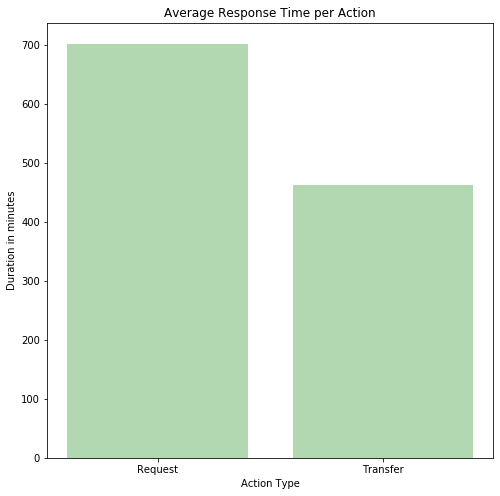

In [37]:
plt.figure(figsize = (8, 8))
plt.title('Average Response Time per Action')
plt.xlabel('Action Type')
plt.ylabel('Duration in minutes')
plt.bar(x = ['Request', 'Transfer'], 
        height = [averageResponseTimeRequest, 
                  averageResponseTimeTransfer], 
                    color = 'g', alpha = 0.3)

### Generate Data Outputs for Customer

In [38]:
CustomerData = {'Action Type': ['Requests', 'Transfers', 'Releases'], 'Approval Rate': [Approval_Rate_Requests, Approval_Rate_Transfers, '--'], 
               'Denial Rate': [Denial_Rate_Requests, Denial_Rate_Transfers, '--'], 
               'Average Response Time': [averageResponseTimeRequest, averageResponseTimeTransfer, '--'],
              'Total Request Time': [totalRequestTime, totalTransferTime, totalReleaseTime]}

In [39]:
Results = pd.DataFrame(data = CustomerData)
Results.set_index('Action Type', drop = True, inplace = True)

In [40]:
Results

,Approval Rate,Denial Rate,Average Response Time,Total Request Time
Action Type,,,,
Requests,0.866462,0.133538,702.391,710037.45
Transfers,0.973282,0.0267176,462.629,140820.80
Releases,--,--,--,512316.25


In [41]:
writer = pd.ExcelWriter('TransactionData.xlsx', engine='xlsxwriter')
Results.to_excel(writer, sheet_name = 'Sheet1')
writer.save()